In [3]:
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()  

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset_PS1_split'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


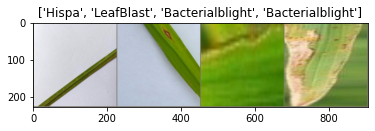

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:


model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.9509 Acc: 0.6582
val Loss: 0.5186 Acc: 0.8373

Epoch 1/24
----------
train Loss: 0.6232 Acc: 0.7734
val Loss: 0.6429 Acc: 0.7680

Epoch 2/24
----------
train Loss: 0.5255 Acc: 0.8196
val Loss: 0.4547 Acc: 0.8528

Epoch 3/24
----------
train Loss: 0.4884 Acc: 0.8257
val Loss: 0.3786 Acc: 0.8813

Epoch 4/24
----------
train Loss: 0.4343 Acc: 0.8477
val Loss: 0.3616 Acc: 0.8733

Epoch 5/24
----------
train Loss: 0.4067 Acc: 0.8523
val Loss: 0.3181 Acc: 0.8947

Epoch 6/24
----------
train Loss: 0.3945 Acc: 0.8613
val Loss: 0.3199 Acc: 0.9001

Epoch 7/24
----------
train Loss: 0.3193 Acc: 0.8866
val Loss: 0.2395 Acc: 0.9173

Epoch 8/24
----------
train Loss: 0.2870 Acc: 0.9011
val Loss: 0.2408 Acc: 0.9162

Epoch 9/24
----------
train Loss: 0.2901 Acc: 0.8952
val Loss: 0.2471 Acc: 0.9194

Epoch 10/24
----------
train Loss: 0.2759 Acc: 0.9008
val Loss: 0.2423 Acc: 0.9243

Epoch 11/24
----------
train Loss: 0.2692 Acc: 0.9028
val Loss: 0.2347 Acc: 0.9264

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


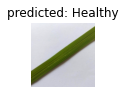

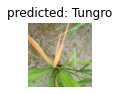

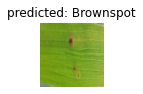

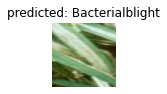

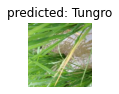

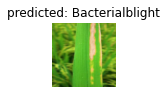

In [14]:
visualize_model(model_ft)

In [13]:
torch.save(model_ft, '/content/drive/MyDrive/Colab Notebooks/model.pt')

In [18]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 7)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

RuntimeError: ignored

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
#author: animesh-007
import os
from glob import glob
from tqdm import tqdm
import shutil
import argparse
import random
random.seed(230)

path = "/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/*"
path2 = "/content/drive/MyDrive/Colab Notebooks/Dataset_PS1_split"

# path = args.path + "/train/*"

## read data inside the folder
for folder in tqdm(glob(path)):
    print(folder)
    files = glob(folder+"/*")
    files.sort() # make sure that the filenames have a fixed order before shuffling
    random.shuffle(files) # shuffles the ordering of filenames (deterministic given the chosen seed)
    split_1 = int(0.8 * len(files))
    train_filenames = files[:split_1]
    val_filenames = files[split_1:]
    
    folder_name = os.path.split(folder)[-1]
    train_destination = f"{path2}/train/{folder_name}"
    val_destination = f"{path2}/val/{folder_name}"
    
    os.makedirs(train_destination,exist_ok=True)
    os.makedirs(val_destination,exist_ok=True)
    
    for train_file in train_filenames:
        shutil.copy(train_file,train_destination)
        
    for val_file in val_filenames:
        shutil.copy(val_file,val_destination)
    
 

  0%|          | 0/7 [00:00<?, ?it/s]

/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/Bacterialblight


 14%|█▍        | 1/7 [00:37<03:46, 37.82s/it]

/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/Tungro


 29%|██▊       | 2/7 [01:11<02:57, 35.54s/it]

/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/Hispa


 43%|████▎     | 3/7 [01:54<02:34, 38.62s/it]

/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/LeafBlast


 57%|█████▋    | 4/7 [02:39<02:03, 41.30s/it]

/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/Healthy


 71%|███████▏  | 5/7 [04:44<02:22, 71.37s/it]

/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/Blast


 86%|████████▌ | 6/7 [05:11<00:56, 56.28s/it]

/content/drive/MyDrive/Colab Notebooks/Dataset_PS1/Brownspot


100%|██████████| 7/7 [07:56<00:00, 68.12s/it]


In [ ]:
!rm -rf "/content/drive/MyDrive/Colab Notebooks/Dataset_PS1_split/train/Dataset_PS1"
!rm -rf "/content/drive/MyDrive/Colab Notebooks/Dataset_PS1_split/val/Dataset_PS1"